In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from model_fc import Net
from scipy import stats
from sklearn import preprocessing



In [9]:
model = Net()
model.load_state_dict(torch.load("models/model_20251020_155551_BS2056_EP1000_LR0.001_VS0.2_KNN5_NFB5"))

<All keys matched successfully>

In [13]:
TRAIN_DATA_PATH = "Data/processed/train_bed_data.npz"

training_data = np.load(TRAIN_DATA_PATH)
X1: np.ndarray = training_data["X1"]
X2: np.ndarray = training_data["X2"]


X = np.concatenate((X1, X2), axis=0)

X = X.reshape(X.shape[0], -1)
scaler = preprocessing.StandardScaler().fit(X)

VAL_DATA_PATH = "Data/processed/val_bed_data.npz"

val_data = np.load(VAL_DATA_PATH)

X1: np.ndarray = val_data["X1"]
X2: np.ndarray = val_data["X2"]

val_X = np.concatenate((X1, X2), axis=0)
val_X = val_X.reshape(val_X.shape[0], -1)
val_X = scaler.transform(val_X)
y_X1_val: np.ndarray = np.load("Data/processed/X1_val_y.npy")
y_X2_val: np.ndarray = np.load("Data/processed/X2_val_y.npy")
val_y = np.log(np.concatenate((y_X1_val, y_X2_val), axis=0) + 1)

pred = model(torch.tensor(val_X, dtype=torch.float32)).detach().numpy()
print(np.linalg.norm(pred - val_y) / len(val_y))
print("Spearman's R:", stats.spearmanr(pred, val_y)[0])

2.4684919787469513
Spearman's R: 0.4204279329040448


In [ ]:

plt.scatter(y, pred)


(array([2.8595e+04, 9.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00,
        2.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.        ,  29.00317383,  58.00634766,  87.00952148,
        116.01269531, 145.01586914, 174.01904297, 203.0222168 ,
        232.02539062, 261.02856445, 290.03173828]),
 <BarContainer object of 10 artists>)

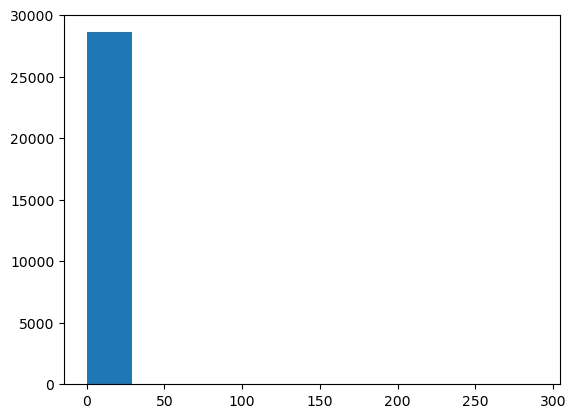

In [8]:
plt.hist(pred)

In [16]:
len(pred)

28620

In [9]:
from model_cnn import GeneModel


X1_val: np.ndarray = np.load("Data/processed/cnn_input_X1_val.npy")
X2_val: np.ndarray = np.load("Data/processed/cnn_input_X2_val.npy")

y_X1_val:  np.ndarray = np.load("Data/processed/X1_val_y.npy")
y_X2_val: np.ndarray = np.load("Data/processed/X2_val_y.npy")


X_val = np.concatenate((X1_val, X2_val), axis=0)
y_val = np.concatenate((y_X1_val, y_X2_val), axis=0)

missing_val = np.any(np.isnan(X_val) | np.isinf(X_val), axis=(1,2))
X_val = X_val[~missing_val, :, :]
y_val = y_val[~missing_val]

net = torch.load("models/cnn_20251020_163812_VLOSS1.356_BS2056_LR0.001_BIN100_W10000", weights_only=False)
# net.load_state_dict(torch.load("models/model_20251020_161703_BS2056_LR0.001_VS0.2_BIN100_W10000.0"))
net.eval()

y_val_pred = net(torch.tensor(X_val, dtype=torch.float32)).detach().numpy()

stats.spearmanr(np.exp(y_val_pred.flatten()), y_val)

SignificanceResult(statistic=np.float64(0.8010774447838555), pvalue=np.float64(0.0))

Generate submission file

In [11]:
import pandas as pd

In [13]:
X3_test = np.load("Data/processed/cnn_input_X3_test.npy")
net.eval()
y_test_pred = net(torch.tensor(X3_test, dtype=torch.float32)).detach().numpy()

df_submission = pd.read_csv('./Data/CAGE-train/X3_test_info.tsv', sep='\t', usecols=[0,1])
df_submission['gex_predicted'] = np.exp(y_test_pred.flatten()) - 1
df_submission.to_csv('Data/submission/gex_predicted.csv', index=True)